# Lab 8: Implement Your Machine Learning Project Plan

In this lab assignment, you will implement the machine learning project plan you created in the written assignment. You will:

1. Load your data set and save it to a Pandas DataFrame.
2. Perform exploratory data analysis on your data to determine which feature engineering and data preparation techniques you will use.
3. Prepare your data for your model and create features and a label.
4. Fit your model to the training data and evaluate your model.
5. Improve your model by performing model selection and/or feature selection techniques to find best model for your problem.


### Import Packages

Before you get started, import a few packages.

In [1]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
import seaborn as sns

<b>Task:</b> In the code cell below, import additional packages that you have used in this course that you will need for this task.

In [44]:
# YOUR CODE HERE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
import tensorflow.keras as keras
import time
from sklearn.metrics import roc_auc_score
from keras import layers
import gensim



## Part 1: Load the Data Set


I chose the book reviews dataset becasue I wanted to expand upon NLP and learn more about deep neural networks. The overall structure of my model is word embeddings that are mapped to tokens and fed into a recurrent neural network. The word embeddings are input using an embedding layer, it goes through 2 LSTM layers and then an output layer.
I wanted to use word embeddings because they aren't sparse like other vectorizers and uitilzes the semantic context between each word through cosine similarity

Because what I wanted to do was a bit out of the scope of what we covered in class, I used the following resources to create a shell for my model and figure out how to process word embeddings: 
<a href="https://towardsdatascience.com/machine-learning-word-embedding-sentiment-classification-using-keras-b83c28087456">word embeddings tutoiral</a>
<a href="https://www.google.com/url?q=https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test&sa=D&source=docs&ust=1691811932916951&usg=AOvVaw04Jx8dffs2JwJipeaD3cKQ">how to split data into a val set</a>
<a href="https://keras.io/guides/working_with_rnns/#:~:text=model%20%3D%20keras.Sequential%28%29%20%23%20Add%20an%20Embedding%20layer,a%20Dense%20layer%20with%2010%20units.%20model.add%28layers.Dense%2810%29%29%20model.summary%28%29">Keras RNN Documentation</a>
<a href="https://danijar.com/tips-for-training-recurrent-neural-networks/">Optimizing</a>
<a href="https://machinelearningmastery.com/gentle-introduction-long-short-term-memory-networks-experts/">LSTM</a>
<a href="https://www.bing.com/search?q=gru+layers+in+rnn&cvid=d4fca12d48024661902a22055ced9c00&aqs=edge.0.69i59j69i57j0l5j46j69i60.1461j0j9&FORM=ANAB01&PC=U531">GRU</a>

In [3]:
# YOUR CODE HERE
filename = os.path.join(os.getcwd(), "data", "bookReviewsData.csv")
df = pd.read_csv(filename, header=0)

## Part 2: Exploratory Data Analysis

The next step is to inspect and analyze your data set with your machine learning problem and project plan in mind. 

This step will help you determine data preparation and feature engineering techniques you will need to apply to your data to build a balanced modeling data set for your problem and model. These data preparation techniques may include:
* addressing missingness, such as replacing missing values with means
* renaming features and labels
* finding and replacing outliers
* performing winsorization if needed
* performing one-hot encoding on categorical features
* performing vectorization for an NLP problem
* addressing class imbalance in your data sample to promote fair AI


<h2>EDA</h2>
Changed the column name so there's no whitespace. Checked for class imbalance and null values. Changed Review column format so its numbers instead of booleans for easier processing

In [4]:
# YOUR CODE HERE

df.rename(columns = {'Positive Review':'is_Positive'}, inplace = True)
#no class imbalance its like 980 positive 993 negative
print(df['is_Positive'].value_counts()[False])
print(df['is_Positive'].value_counts()[True])
print('no class imbalance')
print('are there any null values?', df.isna().any())
df['is_Positive']= df['is_Positive'].astype(int)
print(df.head())

993
980
no class imbalance
are there any null values? Review         False
is_Positive    False
dtype: bool
                                              Review  is_Positive
0  This was perhaps the best of Johannes Steinhof...         True
1  This very fascinating book is a story written ...         True
2  The four tales in this collection are beautifu...         True
3  The book contained more profanity than I expec...        False
4  We have now entered a second time of deep conc...         True


In [6]:
df.head()


,Review,is_Positive
0,This was perhaps the best of Johannes Steinhof...,1
1,This very fascinating book is a story written ...,1
2,The four tales in this collection are beautifu...,1
3,The book contained more profanity than I expec...,0
4,We have now entered a second time of deep conc...,1


<h2>Possible Bias in Dataset </h2>
I noticed the number of positive reviews with male pronouns was double
the amount of positive reviews with female pronouns, implying there's more positive reviews for male authors than female.
I decided to use gendered pronouns as a stopwords list to clean the data with to prevent gender bias as a preventative measure.
If I hadn't the model could fall into allocative bias, not recommending books by female authors as often than male.

In [7]:
female_pronouns = [ 'she', 'her']
male_pronouns = ['he', 'him', 'his']

# Combine the target words into a regular expression pattern
m_pattern = r'\b(?:' + '|'.join(male_pronouns) + r')\b'
f_pattern =  r'\b(?:' + '|'.join(female_pronouns) + r')\b'

male_df = df[df['Review'].str.contains(m_pattern, case=False, na=False)]
female_df = df[df['Review'].str.contains(f_pattern, case=False, na=False)]
print('how many reviews with male pronouns that are positive:', (male_df['is_Positive'] == 1).sum())
print('how many reviews with female pronouns are positive:',(female_df['is_Positive'] == 1).sum())

how many reviews with male pronouns that are positive: 359
how many reviews with female pronouns are positive: 168


In [8]:
!pip install nltk

Defaulting to user installation because normal site-packages is not writeable


In [9]:
import nltk
import string
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords


[nltk_data] Downloading package punkt to /home/codio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/codio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<h2>Preprocess Data and Tokenize it</h2>
While cutting stopwords usually improves model performance, I noticed that the more stopwords I excluded, the worse the model performed, this could be because I'm not working with very long documents (each review is a paragraph each) or because the word vectors/ RNN are able to better use the context of stopwords to make predictions.
So i only took out the gendered pronouns

In [ ]:
'''
review_lines = list()
liness = df['Review'].values.tolist()

lines = df['Review']
lines = lines.apply(lambda row: gensim.utils.simple_preprocess(row))

for line in liness:
    tokens = word_tokenize(line)
    tokens = [w.lower() for w in tokens]
    table = str.maketrans('','',string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    words = [word for word in stripped if word.isalpha()]
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    review_lines.append(words)
print(review_lines)
'''

In [59]:
review_lines = []  # Initialize the list to store cleaned lines

# Preprocess the lines using simple_preprocess and remove stop words
lines = df['Review']
stop_words = ['he', 'his', 'him', 'she', 'her', 'hers']

for line in lines:
    cleaned_line = [word for word in gensim.utils.simple_preprocess(line) if word not in stop_words]
    review_lines.append(cleaned_line)

print('how many examples : ',len(review_lines))


how many examples :  1973


<h2>Creating the Word Embeddings Using Word2Vec</h2>

In [60]:
EMBEDDING_DIM = 100
model = gensim.models.Word2Vec(sentences = review_lines, vector_size = EMBEDDING_DIM, window = 5, workers = 4, min_count = 1)
words = list(model.wv.key_to_index)
print('vocabulary size', len(words))

vocabulary size 20837


In [61]:
model.wv.most_similar('trilogy')

[('premise', 0.995363175868988),
 ('unfortunately', 0.9951717257499695),
 ('version', 0.9941315650939941),
 ('volume', 0.9941017031669617),
 ('place', 0.9940797090530396),
 ('reference', 0.9940342307090759),
 ('text', 0.9939666390419006),
 ('wonderful', 0.9939011335372925),
 ('plot', 0.9938108921051025),
 ('sad', 0.9933741092681885)]


Professor Osuno asked me to create a wordcloud for the most frequent words 
When I tried the following code I got this error:: ValueError: Only supported for TrueType fonts

top25 = model.wv.index_to_key[:25] 
from wordcloud import WordCloud
text = ' '.join(list(top25))

wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(text)


plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

I tried specifying the font_path hyperparameter to use a font already installed in this enviornment but I was gettign the same errors. Additinoally I tried updating the wordcloud package and got this error:: Defaulting to user installation because normal site-packages is not writeable Requirement already 

I believe the Codio Jupyter Notebook enviornment is contributing to these errors and the word cloud would otherwise work on another IDE

<h2>Creating a Dictionary With Word:Vector Pairs</h2>

In [62]:
#load the wordembeddings as a dict of words to vectors
filename = 'book_review_word2vec.txt'
model.wv.save_word2vec_format(filename, binary = False)
embeddings_dictionary = {}
f = open(os.path.join('', 'book_review_word2vec.txt'), encoding = 'utf-8')
#so one line of f is the word corresponding with a long integer vector
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_dictionary[word] = coefs
f.close()

You can't just put the word vectors straight into a neural network 
so they need to be tokenized and put into an embedding layer rather than as input for like a normal dense layer

In [63]:
#convert word embedding into a tokenized vector. maps to the index of a single vector in the embeddings layer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(review_lines)
sequences = tokenizer_obj.texts_to_sequences(review_lines)

#this is to standardize the length of the vectors which i guess are now sequences 
#using sequence paddings

word_index = tokenizer_obj.word_index
#word index is like a dictionary of a word and a number 1-20843
review_pad = pad_sequences(sequences, maxlen = 100)
#so in each index of review pad is a bunch of numbers based on the embeddings
# theres always 100 numbers at each index because thats what maxlen is
#if vector is <100 then add 0s
is_Positive = df['is_Positive'].values
#max_len is a tunable hyperparameter



In [ ]:
#so now were mapping the embeddings from word2vec to the tokenizer vocab to make a matrix
num_words = len(word_index)+1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
#embedding_matrix is the final var that you input into the embedding layer in final model

## Part 3: Implement Your Project Plan

<b>Task:</b> Use the rest of this notebook to carry out your project plan. You will:

1. Prepare your data for your model and create features and a label.
2. Fit your model to the training data and evaluate your model.
3. Improve your model by performing model selection and/or feature selection techniques to find best model for your problem.


Add code cells below and populate the notebook with commentary, code, analyses, results, and figures as you see fit.

Now Im going to create the neural net starting with an embedding layer that will take in our sequences/embeddings/dictionary/matrices

In [65]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU 
#those are diff types of rnn layers
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from tensorflow.keras.metrics import AUC, Precision

<h2>What are the RNN Layers?</h2>
<ul>
    <li>Embedding - maps input information from a high-dimensional to a lower-dimensional space</li>
<li>LSTM - Solves the vanishing gradient problem (gradient becomes too small to update weights) cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell. theres a cell, Forget gate, input and output gates</li>
<li>GRU - Like LSTM but fewer parameters and lacks an output gate. Reset and update gates no long range memory cell</li>
</ul>

Now I'm going to do a train/val/split where validation set is 20% of the total data
basically u take the review_pad sequence, randomize all the indices and the data up

In [66]:
indices = np.arange(review_pad.shape[0])
np.random.shuffle(indices)
review_pad = review_pad[indices]
is_Positive = is_Positive[indices]


#so idk how to get 3 splits with train_test_split so i did two test train splits on top of each other

X, X_test, y, y_test = train_test_split(review_pad,is_Positive,test_size=0.2,train_size=0.8)
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size = 0.25,train_size =0.75)

<h2> Performing A Grid Search For Best Params </h2>
I'm trying to optimize the number of units for each layer as well as the optimizer function

In [84]:
from keras.wrappers.scikit_learn import KerasClassifier
def build_clf(unit1, unit2, losses):
  # creating the layers of the RNN
    model = Sequential()
    embedding_layer = Embedding(num_words, EMBEDDING_DIM, 
                           embeddings_initializer = Constant(embedding_matrix),
                           input_length = 100,
                           trainable = False)
    model.add(embedding_layer)
    model.add(LSTM(units=unit1, dropout = .20, recurrent_dropout = .20, return_sequences = True))
    model.add(LSTM(units=32, dropout = .20, recurrent_dropout = .20, return_sequences = True))
    model.add(LSTM(units=unit2, dropout = .20, recurrent_dropout = .20))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(loss=losses, optimizer='adam', metrics=[AUC()])
    return model

In [85]:
keras_model = KerasClassifier(build_fn=build_clf)

In [86]:
from sklearn.metrics import roc_auc_score, make_scorer
params = {
    "unit1": [16, 32, 64, 128],
    "unit2": [32, 64, 128, 160],
}
scoring = make_scorer(roc_auc_score)

# Perform grid search with AUC as the scoring metric
print("beginning grid search")
grid = GridSearchCV(keras_model, params, scoring=scoring, cv=3)
grid_search = grid.fit(X_train, y_train)
print('Done')
print("best parameters:", grid_search.best_params_)

beginning grid search
25/25 [==============================] - 14s 288ms/step - loss: 0.6964 - auc_232: 0.5200


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: in user code:

    /usr/local/lib/python3.6/dist-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.6/dist-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for

37/37 [==============================] - 14s 180ms/step - loss: 0.6955 - auc_260: 0.5014
Done
best parameters: {'losses': 'binary_crossentropy', 'unit1': 32, 'unit2': 32}


<h1> Creating the Final Model </h1>
<h3>Why I chose the Layer Type </h3>
The LSTM is more complex than GRU because it has more gates and a memory cell that can better contextualize words in a document in long range dependencies
<h3>Why I Chose the AUC Metric</h3>
Because this model can be used for a recommender system, its worse to have a false positive than a false negative because you dont want to recommend a book thats disliked by readers. Because of that I ruled out recall. AUC is the amount of true positives over false positives, AUC also takes into account the probability that each prediction will be right so I chose AUC as my metric seems to be better for classifying text data than precision is.

In [97]:
model = Sequential()
embedding_layer = Embedding(num_words, EMBEDDING_DIM, 
                           embeddings_initializer = Constant(embedding_matrix),
                           input_length = 100,
                           trainable = False)
model.add(embedding_layer)
model.add(LSTM(units=32, dropout = .20, recurrent_dropout = .20, return_sequences = True))
model.add(LSTM(units=128, dropout = .20, recurrent_dropout = .20))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[AUC()])
model.summary()

Model: "sequential_267"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_267 (Embedding)    (None, 100, 100)          2083800   
_________________________________________________________________
lstm_533 (LSTM)              (None, 100, 32)           17024     
_________________________________________________________________
lstm_534 (LSTM)              (None, 128)               82432     
_________________________________________________________________
dense_267 (Dense)            (None, 1)                 129       
Total params: 2,183,385
Trainable params: 99,585
Non-trainable params: 2,083,800
_________________________________________________________________


Theres a lot less trainable params than total params because I created  the word embeddings dictionary
myself so in theory this will make it all train faster.



In [98]:
print('begin training process')
model.fit(X_train, y_train, batch_size = 128, epochs = 49, validation_data=(X_val, y_val), 
         verbose = 2)
print('training process done!!')

begin training process
Epoch 1/50
10/10 - 20s - loss: 0.6937 - auc_267: 0.5118 - val_loss: 0.6903 - val_auc_267: 0.5553
Epoch 2/50
10/10 - 3s - loss: 0.6935 - auc_267: 0.5293 - val_loss: 0.6954 - val_auc_267: 0.5688
Epoch 3/50
10/10 - 3s - loss: 0.6918 - auc_267: 0.5344 - val_loss: 0.6864 - val_auc_267: 0.5653
Epoch 4/50
10/10 - 3s - loss: 0.6873 - auc_267: 0.5662 - val_loss: 0.6853 - val_auc_267: 0.5745
Epoch 5/50
10/10 - 3s - loss: 0.6868 - auc_267: 0.5660 - val_loss: 0.6830 - val_auc_267: 0.5795
Epoch 6/50
10/10 - 3s - loss: 0.6824 - auc_267: 0.5850 - val_loss: 0.6779 - val_auc_267: 0.5948
Epoch 7/50
10/10 - 3s - loss: 0.6806 - auc_267: 0.5907 - val_loss: 0.6816 - val_auc_267: 0.6023
Epoch 8/50
10/10 - 3s - loss: 0.6782 - auc_267: 0.5960 - val_loss: 0.6616 - val_auc_267: 0.6445
Epoch 9/50
10/10 - 4s - loss: 0.6705 - auc_267: 0.6221 - val_loss: 0.6604 - val_auc_267: 0.6512
Epoch 10/50
10/10 - 5s - loss: 0.6812 - auc_267: 0.5850 - val_loss: 0.6771 - val_auc_267: 0.6253
Epoch 11/50
10/

Epoch 1/50
10/10 [==============================] - 4s 350ms/step - loss: 0.6023 - auc_267: 0.7377 - val_loss: 0.6001 - val_auc_267: 0.7385
Epoch 2/50
10/10 [==============================] - 4s 421ms/step - loss: 0.6126 - auc_267: 0.7260 - val_loss: 0.6192 - val_auc_267: 0.7138
Epoch 3/50
10/10 [==============================] - 3s 345ms/step - loss: 0.6232 - auc_267: 0.7106 - val_loss: 0.5946 - val_auc_267: 0.7547
Epoch 4/50
10/10 [==============================] - 4s 386ms/step - loss: 0.6253 - auc_267: 0.7049 - val_loss: 0.6027 - val_auc_267: 0.7649
Epoch 5/50
10/10 [==============================] - 4s 375ms/step - loss: 0.6174 - auc_267: 0.7240 - val_loss: 0.6271 - val_auc_267: 0.7269
Epoch 6/50
10/10 [==============================] - 4s 426ms/step - loss: 0.5956 - auc_267: 0.7453 - val_loss: 0.6342 - val_auc_267: 0.7342
Epoch 7/50
10/10 [==============================] - 4s 434ms/step - loss: 0.6054 - auc_267: 0.7326 - val_loss: 0.6138 - val_auc_267: 0.7369
Epoch 8/50
10/10 [==

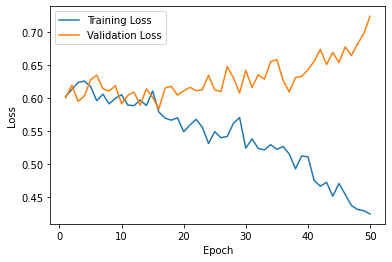

In [103]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=49, batch_size=128, verbose = 0)

plt.plot(range(1, 50 + 1), history.history['loss'], label='Training Loss')
plt.plot(range(1, 50 + 1), history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [100]:
loss, auc = model.evaluate(X_test, y_test)


print('Loss: ', str(loss) , 'Auc: ', str(auc))

13/13 [==============================] - 0s 36ms/step - loss: 0.6690 - auc_267: 0.6535
Loss:  0.6689580678939819 Auc:  0.6534959077835083
